In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Load the dataset
df = pd.read_csv('seasonal_coconut_yield_data_4.csv', parse_dates=['Date'], index_col='Date')


In [3]:
df.head(10)

,Soil Moisture (10 cm) (%),Soil Moisture (20 cm) (%),Soil Moisture (30 cm) (%),Plant Age (years),Temperature (°C),Humidity (%),Rainfall (mm),Rain Status (0/1),Coconut Count
Date,,,,,,,,,
1970-09-30,38.863846,47.555648,26.644738,4,34.766176,67.544036,0.000000,0,250
1970-10-31,36.738342,25.419726,58.169016,9,28.262205,75.123845,0.000000,0,250
1970-11-30,26.114338,42.271098,32.991594,4,27.999294,69.486173,0.000000,0,268
1970-12-31,24.999575,21.721755,45.415754,6,26.517429,71.956160,0.000000,0,289
1971-01-31,32.527440,32.321946,42.662305,2,34.339780,62.621173,0.000000,0,341
1971-02-28,33.758269,29.321460,43.007136,7,34.099302,74.345238,8.772845,1,352
1971-03-31,36.609157,33.706642,41.628793,4,32.569277,73.782422,12.968252,1,349
1971-04-30,25.671458,23.334526,26.064556,4,33.777494,64.079892,0.000000,0,358
1971-05-31,16.365258,49.155359,42.941534,1,29.694068,77.157156,0.000000,0,325


In [4]:
train_size = int(len(df) * 0.8)
train = df['Coconut Count'][:train_size]
test = df['Coconut Count'][train_size:]

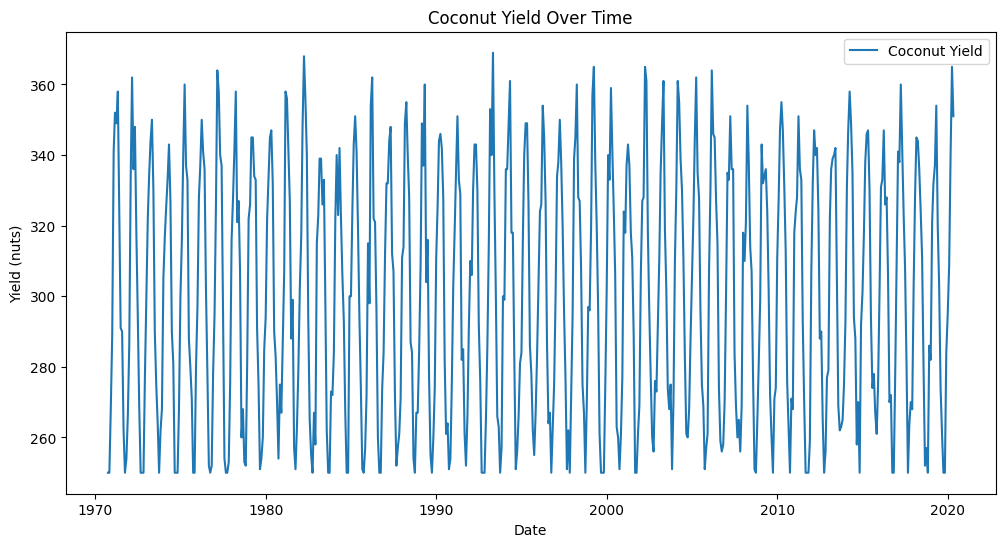

In [5]:
# Visualize the time series data
plt.figure(figsize=(12, 6))
plt.plot(df['Coconut Count'], label='Coconut Yield')
plt.title('Coconut Yield Over Time')
plt.xlabel('Date')
plt.ylabel('Yield (nuts)')
plt.legend()
plt.show()

In [6]:
# Test for stationarity (ADF test)
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])

In [7]:
test_stationarity(df['Coconut Count'])

ADF Statistic: -6.419861531342375
p-value: 1.802729218868902e-08


In [8]:
def train_evaluate_model(model_name, train, test):
    if model_name == 'ARIMA':
        auto_model = auto_arima(train, seasonal=False, stepwise=True, suppress_warnings=True)
        model = ARIMA(train, order=auto_model.order)
        fitted = model.fit()
        forecast = fitted.forecast(steps=len(test))
        fitted_model = fitted
        
    elif model_name == 'Holt-Winters':
        model = ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add')
        fitted = model.fit()
        forecast = fitted.forecast(len(test))
        fitted_model = fitted
        
    elif model_name == 'SARIMA':
        model = sm.tsa.statespace.SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
        fitted = model.fit()
        forecast = fitted.forecast(steps=len(test))
        fitted_model = fitted
    
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    accuracy = 100 * (1 - rmse/np.mean(test))
    
    return fitted_model, forecast, {'MAE': mae, 'RMSE': rmse, 'Accuracy': accuracy}

In [9]:
models = ['ARIMA', 'Holt-Winters', 'SARIMA']
results = {}
best_accuracy = -np.inf
best_model = None

for model_name in models:
    model, forecast, metrics = train_evaluate_model(model_name, train, test)
    results[model_name] = {'model': model, 'forecast': forecast, 'metrics': metrics}
    
    if metrics['Accuracy'] > best_accuracy:
        best_accuracy = metrics['Accuracy']
        best_model = model_name

c:\Users\Thanuja Dhananjaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Thanuja Dhananjaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Thanuja Dhananjaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\Thanuja Dhananjaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

In [10]:
for model_name, result in results.items():
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {result['metrics']['Accuracy']:.2f}%")
    print(f"MAE: {result['metrics']['MAE']:.2f}")
    print(f"RMSE: {result['metrics']['RMSE']:.2f}")

print(f"\nBest Model: {best_model} with {best_accuracy:.2f}% accuracy")


ARIMA Results:
Accuracy: 96.98%
MAE: 7.44
RMSE: 9.10

Holt-Winters Results:
Accuracy: 97.06%
MAE: 7.36
RMSE: 8.86

SARIMA Results:
Accuracy: 97.06%
MAE: 7.36
RMSE: 8.86

Best Model: Holt-Winters with 97.06% accuracy


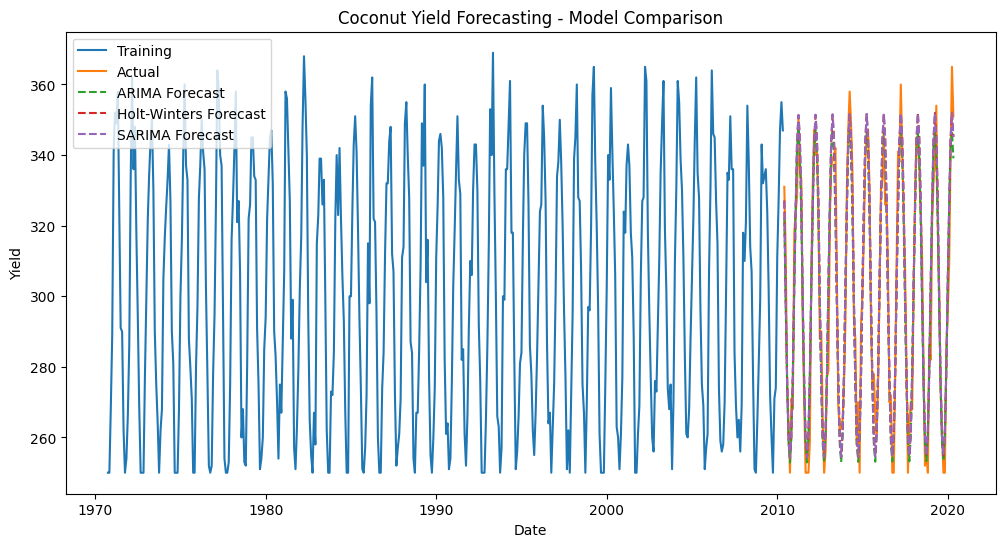

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual')
for model_name, result in results.items():
    plt.plot(test.index, result['forecast'], label=f'{model_name} Forecast', linestyle='--')
plt.title('Coconut Yield Forecasting - Model Comparison')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.show()

In [12]:
future_steps = 6
if best_model == 'ARIMA' or best_model == 'SARIMA':
    best_forecast = results[best_model]['model'].forecast(steps=future_steps)
elif best_model == 'Holt-Winters':
    best_forecast = results[best_model]['model'].forecast(future_steps)

future_dates = pd.date_range(start=test.index[-1], periods=future_steps+1, freq='M')[1:]
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Yield': best_forecast
})

print("\nNext 6 months predictions:")
print(forecast_df)


Next 6 months predictions:
                 Date  Predicted_Yield
2010-05-31 2020-05-31       327.133498
2010-06-30 2020-06-30       298.982053
2010-07-31 2020-07-31       276.145319
2010-08-31 2020-08-31       259.525252
2010-09-30 2020-09-30       254.222961
2010-10-31 2020-10-31       261.412989
